In [104]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from openvino.inference_engine import IECore
import easyocr 
ie  = IECore()
image_path = r'data_images\facts-of-seatbelt-4-293a.jpg'
Video_path = r'data_images\Untitled2.png'
image = cv2.imread(image_path)
def show(image):
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

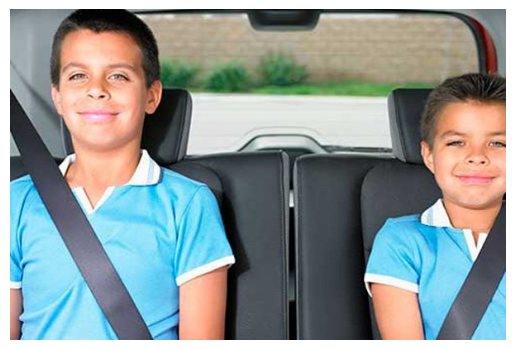

In [105]:
show(image)

In [119]:
image = cv2.resize(image,(600,800))
gray_image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
belt = False
blur = cv2.blur(gray_image,(1,1))
edge = cv2.Canny(blur,50,400)
ps = 0
px1,py1,px2,py1= 0 , 0, 0, 0
lines = cv2.HoughLinesP(edge,1,np.pi/270,30,maxLineGap=20 , minLineLength=170)

In [120]:
def Slope(a,b,c,d):
    return abs(int(d-b)/(c-a))

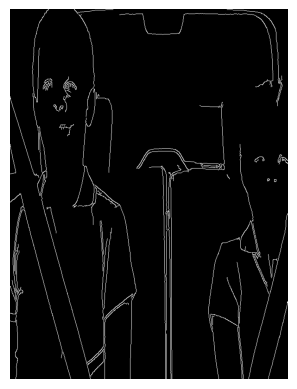

In [121]:
show(edge)

In [123]:
if lines is not None:
    for line in lines:
        x1 ,y1,x2,y2 = line[0]
         # Slope Of Current Line
        if (x2-x1) ==0:
            s = 0
        else:
            s = Slope(x1,y1,x2,y2)
    
        # If Current Line's Slope Is Greater Than 0.7 And Less Than 2
        if ((s > 0.7) and ( s < 4)):
         
            # And Previous Line's Slope Is Within 0.7 To 2
            if((ps > 0.7) and (ps < 4)):
                
                # And Both The Lines Are Not Too Far From Each Other
                if((((x1 - px1) > 5) and ((x2 - px2) > 5)) or (((y1 - py1) > 5) and ((y2 - py2) > 5))):
                
                    # Plot The Lines On "beltframe"
                    cv2.line(image, (x1, y1), (x2, y2), (0, 0, 255), 3)
                    cv2.line(image, (px1, py1), (px2, py2), (0, 0, 255), 3)

                    # Belt Is Detected
                    print ("Belt Detected")
                    belt = True

        # Otherwise Current Slope Becomes Previous Slope (ps) And Current Line Becomes Previous Line (px1, py1, px2, py2)            
        ps = s
        px1, py1, px2, py2 = line[0]

Belt Detected
Belt Detected


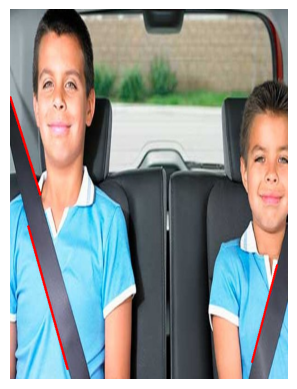

In [124]:
if belt == False:
    print("No Seatbelt detected")

show(image)

In [128]:
def detect_license_plates(video_path):
    license_plate_xml = r'models\vehicle-license-plate-detection-barrier-0106\vehicle-license-plate-detection-barrier-0106.xml'
    license_plate_bin = r'models\vehicle-license-plate-detection-barrier-0106\vehicle-license-plate-detection-barrier-0106.bin'
    net = ie.read_network(model=license_plate_xml, weights=license_plate_bin)
    ext = ie.load_network(network=net, device_name='CPU')
    
    video_capture = cv2.VideoCapture(video_path)
    license_plate_images = []
    
    while True:
        ret, frame = video_capture.read()
        
        if not ret:
            break
        
        resized_frame = cv2.resize(frame, (300, 300))
        image_for_inference = np.transpose(resized_frame, (2, 0, 1))
        image_for_inference = np.expand_dims(image_for_inference, axis=0)
        results = ext.infer(inputs={'Placeholder': image_for_inference})
        
        # Retrieve the output blob
        output_blob = next(iter(net.outputs))
    
        # Process the output
        output = results[output_blob]
        boxes = output[0][0]
        
        if output.shape[0] == 0:
            print("No license plates detected.")
        else:
            for box in boxes:
                confidence = box[2]
                if confidence > 0.005: 
                    # Filter detections based on confidence threshold
                    x_min = int(box[3] * frame.shape[1])
                    y_min = int(box[4] * frame.shape[0])
                    x_max = int(box[5] * frame.shape[1])
                    y_max = int(box[6] * frame.shape[0])
                    cv2.rectangle(frame, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
                    license_plate_image = frame[y_min:y_max, x_min:x_max]
                    license_plate_images.append(license_plate_image)
        
        cv2.imshow('License Plate Detection', frame)
        
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    
    video_capture.release()
    cv2.destroyAllWindows()
    
    return license_plate_images


In [126]:
extracted_text = []
def extract_texts(image):
    for i in range(len(image)):    
        image_for_inference = cv2.cvtColor(image[i], cv2.COLOR_BGR2GRAY)
        reader = easyocr.Reader(['en'],gpu=True)
        
        results = reader.readtext(image_for_inference)
        for detection in results:
                box, text, confidence = detection
                extracted_text.append(text)
        return

In [127]:
license_plate_images = detect_license_plates(image)
extract_texts(license_plate_images)
extracted_text

error: OpenCV(4.8.0) :-1: error: (-5:Bad argument) in function 'VideoCapture'
> Overload resolution failed:
>  - Can't convert object to 'str' for 'filename'
>  - VideoCapture() missing required argument 'apiPreference' (pos 2)
>  - Argument 'index' is required to be an integer
>  - VideoCapture() missing required argument 'apiPreference' (pos 2)


In [129]:
def obtain_predicted_letter(decoder_output):
    # Define the list of supported symbols
    supported_symbols = "?0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ"

    # Get the index with the highest probability from the decoder output
    predicted_index = np.argmax(decoder_output)

    # Map the index to the corresponding symbol
    predicted_letter = supported_symbols[predicted_index]

    return predicted_letter


text_encoder_xml = r'models\text-recognition-0014\text-recognition-0014.xml'
text_encoder_bin = r'models\text-recognition-0014\text-recognition-0014.bin'
net = ie.read_network(model=text_encoder_xml, weights=text_encoder_bin)
ext = ie.load_network(network=net, device_name='CPU')

resized_image = cv2.resize(license_plate_images[0], (256, 64))
image_for_inference = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
image_for_inference = np.expand_dims(image_for_inference, axis=0)
image_for_inference = np.expand_dims(image_for_inference, axis=1)  # Add channel dimension

results_encoder = ext.infer(inputs={'imgs': image_for_inference})
decoder_hidden = results_encoder['decoder_hidden']
features = results_encoder['features']

text_decoder_xml = r'models\text-recognition-0016\text-recognition-0016-decoder\text-recognition-0016-decoder.xml'
text_decoder_bin = r'models\text-recognition-0016\text-recognition-0016-decoder\text-recognition-0016-decoder.bin'
net_decoder = ie.read_network(model=text_decoder_xml, weights=text_decoder_bin)
ext_decoder = ie.load_network(network=net_decoder, device_name='CPU')

decoder_input = np.array([0])  # Placeholder for previous predicted letter
hidden = decoder_hidden
text = ""

char_dict = {symbol: i for i, symbol in enumerate("0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ", start=1)}

for step in range(10):
    results_decoder = ext_decoder.infer(inputs={'decoder_input': decoder_input, 'features': features, 'hidden': hidden})
    decoder_hidden = results_decoder['decoder_hidden']
    decoder_output = results_decoder['decoder_output']
    
    # Obtain the predicted letter from the decoder output
    predicted_letter = obtain_predicted_letter(decoder_output)
    text += predicted_letter
    print(predicted_letter)
    
    # Set decoder_input to the predicted letter index for the next time step
    decoder_input = np.array([char_dict[predicted_letter.lower()]], dtype=np.int32)



NameError: name 'license_plate_images' is not defined

# Road Segmentaion


In [130]:
def Road(video_path):
    semantic_xml = r'models\semantic-segmentation-adas-0001\semantic-segmentation-adas-0001.xml'
    semantic_bin = r'models\semantic-segmentation-adas-0001\semantic-segmentation-adas-0001.bin'
    net = ie.read_network(model = semantic_xml , weights = semantic_bin)
    ext = ie.load_network(network = net , device_name='CPU')
    
    video_capture = cv2.VideoCapture(video_path)
    
    while True:
        ret, frame = video_capture.read()
        
        if not ret:
            break
        window_width = 800
        window_height = 600
        input_image = cv2.resize(frame, (2048, 1024))
        input_image = input_image.transpose((2, 0, 1))
        input_image = np.expand_dims(input_image, axis=0)


        result = ext.infer(inputs={'data': input_image})


        # Get the segmentation map
        segmentation_map = result['4832.1'][0,0]

        classes_of_interest = ['road','car']
        class_names = [
            "road", "sidewalk", "building", "wall", "fence", "pole", "traffic light", "traffic sign",
            "vegetation", "terrain", "sky", "person", "rider", "car", "truck", "bus", "train",
            "motorcycle", "bicycle", "ego-vehicle"
        ]
        # Create a mask for the classes of interest
        mask = np.zeros_like(segmentation_map, dtype=np.uint8)
        for class_idx, class_name in enumerate(class_names):
            if class_name in classes_of_interest:
                mask[segmentation_map == class_idx] = 255

        mask = cv2.resize(mask, (window_width, window_height))
        cv2.imshow('License Plate Detection', mask)
        
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    
    video_capture.release()
    cv2.destroyAllWindows()


In [131]:
Video_path = r'data_videos\1234.mp4'
Road(Video_path)